In [1]:
import os

IMG_PATH = "../analysis/_img"
CACHE_PATH = "../analysis/_cache"
if not os.path.isdir(IMG_PATH): os.mkdir(IMG_PATH)
if not os.path.isdir(CACHE_PATH): os.mkdir(CACHE_PATH)

import numpy as np
import scipy.stats as st
import pandas as pd
from tqdm import tqdm
import pickle
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u

import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
import seaborn as sns

sns.set_theme(context="talk", style="ticks", palette="colorblind", color_codes=True, font_scale=1.2)

from MaStarChecks.io import load_libraries
from MaStarChecks.plotting.styles import *


PROCESSED_PATH = os.path.join("../fitting/_data", "processed-libraries-v3.0.2-clean")
CLASSIFIED_PATH = "../fitting/_data/classified-mastar-v3.0.2-cleaned-v2-gsl"

LABELS = ("MaStar",)
Y_COLUMNS = ["TEFF", "LOGG", "MET", "ALPHAM"]

COLOR = "#7E00A7"
CMAP = "plasma_r"

def get_range(x, data=None, n=2):
    if data is None:
        xmin, xmax = x.min(), x.max()
    else:
        xmin, xmax = data[x].min(), data[x].max()
    return np.linspace(xmin, xmax, n)

from scipy.optimize import lsq_linear, least_squares

def model(p, x):
    return p[0]*x + p[1]

def residuals_(p, x, y):
    return y - model(p, x)

In [2]:
spectra_m20, catalogue_m20 = load_libraries(labels=LABELS, kind="classified-gsl",
                                    libraries_path=CLASSIFIED_PATH, impute_missing=False, use_cache=True,
                                    cache_path=CACHE_PATH, cache_label="M20-cleaned-v2-gsl")
catalogue_m20

ID  RECORD  BIBREF  NAMES PHOTCAT  NEXP            RA  \
0           13-0   28850     NaN    NaN     NaN     6  15h24m04.27s   
1           13-1   28853     NaN    NaN     NaN     6  15h23m54.70s   
2          13-11   28883     NaN    NaN     NaN     6  15h29m17.82s   
3           13-2   28856     NaN    NaN     NaN     6  15h22m34.17s   
4           13-3   28859     NaN    NaN     NaN     6  15h30m54.20s   
...          ...     ...     ...    ...     ...   ...           ...   
22045  7-9860659   54008     NaN    NaN   APASS     4  13h21m41.92s   
22046  7-9862368   46498     NaN    NaN   APASS     2  13h23m04.54s   
22047   7-986892   44510     NaN    NaN   APASS     4  06h58m20.42s   
22048  7-9898583   54005     NaN    NaN   APASS     3  13h34m06.25s   
22049  7-9993863    1233     NaN    NaN   APASS     6  01h36m50.31s   

                 DEC         VCORR         SNR  ...      RADVEL     RVERR  \
0      +41d54m50.04s  9.473056e-06  126.750038  ...  -60.200520  0.801926   
1      +41d30m57.16s  6.521336e-06   90.629297  ...  -65.239136  1.143928   
2      +43d37m48.81s  5.918942e-06   61.619321  ... -185.337082  0.928073   
3      +42d26m50.59s  6.494232e-07   32.136388  ...  -17.858658  1.524976   
4      +42d38m28.17s  0.000000e+00   86.984141  ... -208.675354  1.779905   
...              ...           ...         ...  ...         ...       ...   
22045  +71d49m32.46s  3.590327e-04  172.191246  ...  -10.541465  0.732322   
22046  +72d23m28.82s  4.740399e-07   81.017397  ...    8.358974  0.536108   
22047  -00d56m41.69s  1.760586e-05  354.506690  ...   65.445702  0.933125   
22048  +72d21m25.99s  8.144036e-05  233.660008  ...  -39.651886  0.857135   
22049  +29d39m30.55s  1.170537e-05  318.235739  ...    6.309839  1.035208   

       GOODSP  GOODPH  GOODRV         TEFF      LOGG       MET    ALPHAM  \
0        True    True    True  6139.788845  3.996081 -1.760134  0.525396   
1        True    True    True  6233.449021  4.112953 -1.758262  0.311147   
2        True    True    True  6255.209531  3.878911 -1.535719  0.645552   
3        True    True    True  5961.794413  3.644768 -1.593136  0.697835   
4        True    True    True  6434.936427  4.209989 -2.418077  0.795756   
...       ...     ...     ...          ...       ...       ...       ...   
22045    True    True    True  4914.239810  4.582574 -0.078060  0.018364   
22046    True    True    True  4760.156019  2.240332 -1.041914  0.208304   
22047    True    True    True  7469.459678  4.917704 -2.267156 -0.468670   
22048    True    True    True  4474.667609  3.094349  0.126779  0.063123   
22049    True    True    True  6474.321377  3.980909 -0.349136  0.047671   

       LIBRARY  
0       MaStar  
1       MaStar  
2       MaStar  
3       MaStar  
4       MaStar  
...        ...  
22045   MaStar  
22046   MaStar  
22047   MaStar  
22048   MaStar  
22049   MaStar  

[22050 rows x 29 columns]

In [3]:
f = fits.open("/disk-a/mejia/mastar-checks-data/stellar-libraries/MaStar/mastarall-gaia-ebv-v3_0_1-v1_5_0.fits")
ebv_y19 = Table(f[1].data)[["MANGAID", "EBV"]].to_pandas().set_index("MANGAID").sort_index().loc[catalogue_m20.ID].squeeze()

In [4]:
from dustmaps.sfd import SFDQuery
sfd = SFDQuery()

import dust_extinction
from dust_extinction.parameter_averages import CCM89

RV = 3.1
ext = CCM89(Rv=RV)

ebv_m20 = pd.Series(index=catalogue_m20.ID, data=sfd(SkyCoord(catalogue_m20.RA,catalogue_m20.DEC)))

In [5]:
match_fits = fits.open("../analysis/_data/mastarall-gaia-v3_0_1-v1_5_0.fits")

match_columns = ["MANGAID", "SOURCE_ID", "RA", "DEC", "PARALLAX", "PHOT_G_MEAN_MAG", "BP_RP"]
match_mastar_gaia = Table(match_fits[1].data)[match_columns].to_pandas()
match_mastar_gaia = match_mastar_gaia.rename(columns=lambda s:s.lower())
match_mastar_gaia = match_mastar_gaia.rename(columns={"mangaid":"ID"})

match_mastar_gaia.ID = match_mastar_gaia.ID.str.strip()
match_mastar_gaia = match_mastar_gaia.loc[match_mastar_gaia.ID.isin(catalogue_m20.ID)].reset_index(drop=True)
# match_mastar_gaia = match_mastar_gaia.mask((match_mastar_gaia==-999).any(axis="columns"))
match_mastar_gaia["g"] = match_mastar_gaia.phot_g_mean_mag + 5*np.log10(match_mastar_gaia.parallax) - 10
match_mastar_gaia["d"] = 1 / match_mastar_gaia.parallax
match_mastar_gaia

ID            source_id          ra        dec  parallax  \
0           13-0  1390865480240476288  231.017670  41.913835  0.440606   
1           13-1  1390839882235285248  230.977873  41.515878  0.407556   
2          13-11  1394430818491992832  232.324214  43.630177  0.298796   
3           13-2  1393895940445119104  230.642410  42.447338  0.458070   
4           13-3  1390956396108016512  232.725647  42.641193  0.574062   
...          ...                  ...         ...        ...       ...   
22045  7-9860659  1687790656905111936  200.424588  71.825767  3.106085   
22046  7-9862368  1687923182415999232  200.768703  72.391285  0.105977   
22047   7-986892  3112252981951462400  104.585092  -0.945150  0.199956   
22048  7-9898583  1687521345275773696  203.526363  72.357176  0.551635   
22049  7-9993863   302984482166694656   24.209626  29.658474  1.342489   

       phot_g_mean_mag     bp_rp         g         d  
0            15.054702  0.688834  3.274955  2.269600  
1            15.636861  0.682185  3.687798  2.453649  
2            16.586594  0.707249  3.963471  3.346760  
3            17.638498  0.760212  5.943155  2.183075  
4            15.801737  0.647917  4.596529  1.741973  
...                ...       ...       ...       ...  
22045        13.583573  1.159945  6.044640  0.321949  
22046        13.673251  1.206109 -1.200690  9.436006  
22047        14.916759  0.451539  1.421431  5.001101  
22048        12.730466  1.355581  1.438726  1.812792  
22049        12.269134  0.638510  2.908687  0.744885  

[22050 rows x 9 columns]

In [12]:
mastar_coords = SkyCoord(ra=match_mastar_gaia.ra, dec=match_mastar_gaia.dec, distance=match_mastar_gaia.d, unit=(u.deg,u.deg,u.kpc))
mastar_coords

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    [(231.01767025, 41.9138353 , 2.26960019),
     (230.97787328, 41.51587839, 2.4536493 ),
     (232.32421388, 43.63017652, 3.34676026), ...,
     (104.58509236, -0.94514979, 5.00110134),
     (203.526363  , 72.35717629, 1.8127918 ),
     ( 24.20962571, 29.65847375, 0.74488512)]>

In [7]:
from dustmaps.bayestar import BayestarWebQuery

bst = BayestarWebQuery(version="bayestar2015")
ebv_m21 = pd.Series(index=catalogue_m20.ID, data=bst(mastar_coords, mode="median"))

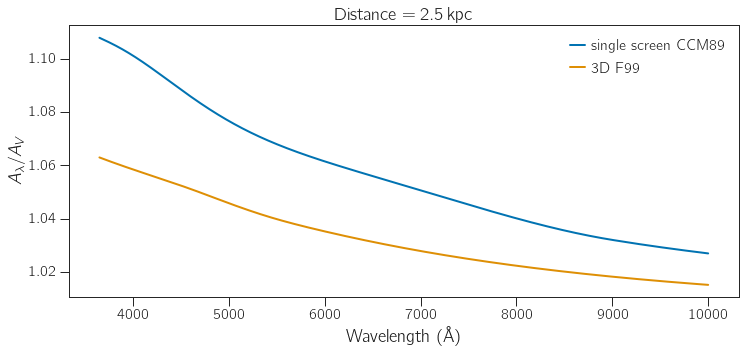

In [8]:
from dust_extinction.parameter_averages import F99, CCM89

idx = 1

ccm = CCM89(Rv=RV)
ext_m20 = ccm.extinguish(spectra_m20.columns.astype("float").values*u.AA, Ebv=ebv_m20.iloc[idx])

f99 = F99(Rv=RV)
ext_m21 = f99.extinguish(spectra_m20.columns.astype("float").values*u.AA, Ebv=ebv_m21.iloc[idx])

plt.figure(figsize=(12,5))
plt.title("$\mathrm{Distance}=%.1f\,$kpc"%(match_mastar_gaia.d.iloc[idx]))
plt.plot(spectra_m20.columns, 1/ext_m20, label="single screen CCM89")
plt.plot(spectra_m20.columns, 1/ext_m21, label="3D F99")
plt.xlabel("Wavelength (\AA)")
plt.ylabel("$A_\lambda/A_V$")
plt.legend(loc=0)

Text(0.5, 0, '$\\Delta E(B-V)$')

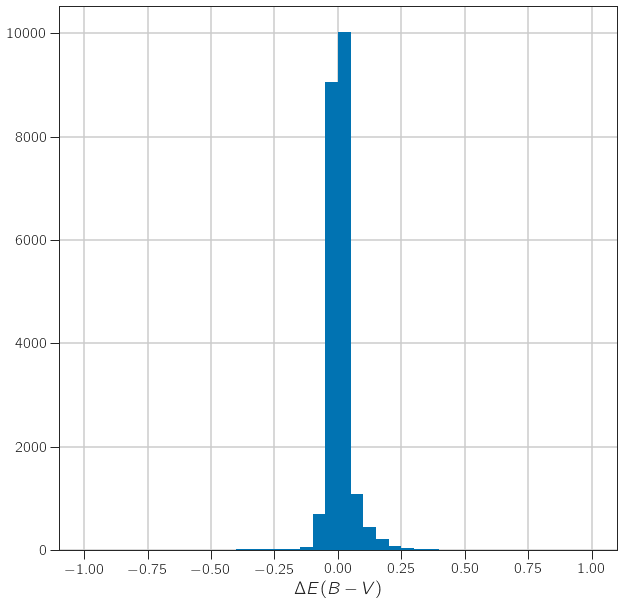

In [9]:
(ebv_m21-ebv_y19).hist(range=(-1,+1), bins=40)
plt.xlabel(r"$\Delta E(B-V)$")